In [6]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim

from torch import Tensor
from torch.nn.parameter import Parameter, UninitializedParameter

We write classes for linear and singular models that we are going to use train SGD

In [7]:
class SingModel(torch.nn.Module):
    def __init__(self, w0:float, d1:int, d2:int, in_features:int, out_features:int) -> None:
         super(SingModel, self).__init__()
         self.w0 = w0
         self.d1 = d1
         self.d2 = d2
         self.weight = Parameter(torch.randn((out_features, in_features)))
         
    def forward(self, input:Tensor):
        sing1 = (self.weight - self.w0)**self.d1
        sing2 = (self.weight - self.w0)**self.d2
        return input * sing1 * sing2

# Defining the Linear Model
class LinearModel(nn.Module):
    def __init__(self):
        super(LinearModel, self).__init__()
        self.linear = nn.Linear(1, 1)
        # Random weight initialization
        self.linear.weight.data.normal_()
    def forward(self, x):
        return self.linear(x)

Generate some data

In [18]:
torch.manual_seed(42) # for reproducibility
num_samples = 100
x_data = torch.normal(0, 1, (num_samples, 1))
y_data = torch.normal(0, 1, (num_samples, 1))

Train a Linear model and visualise the loss curve

Epoch 0, Loss: 1.6868435144424438, w: 0.47008785605430603
Epoch 100, Loss: 0.793721616268158, w: 0.06408367305994034
Epoch 200, Loss: 0.7805586457252502, w: 0.01764325611293316
Epoch 300, Loss: 0.7803634405136108, w: 0.012440051883459091
Epoch 400, Loss: 0.7803606390953064, w: 0.011874990537762642
Epoch 500, Loss: 0.7803606390953064, w: 0.011816632002592087
Epoch 600, Loss: 0.7803605794906616, w: 0.011811129748821259
Epoch 700, Loss: 0.7803605794906616, w: 0.011810705065727234
Epoch 800, Loss: 0.7803605794906616, w: 0.011810689233243465
Epoch 900, Loss: 0.7803605794906616, w: 0.011810689233243465


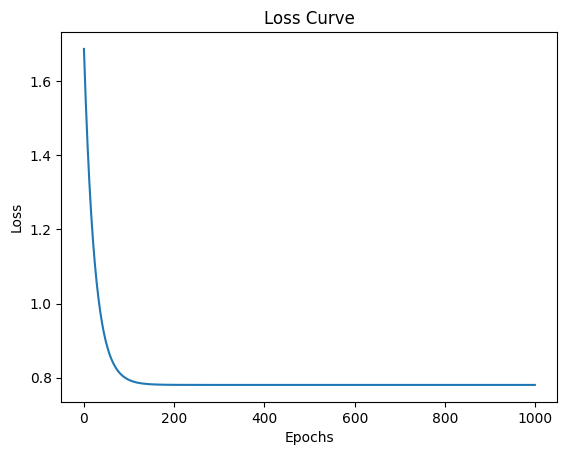

In [19]:
# Loss tracking
loss_values = []

# Tracking weights
weights_over_epochs = []

# Model Initialization
model = LinearModel()

# Loss and Optimizer
loss_function = nn.MSELoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)

# Training the Model
num_epochs = 1000
for epoch in range(num_epochs):
    # Forward pass
    y_pred = model(x_data)
    loss = loss_function(y_pred, y_data)

    # Backward pass and optimization
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Tracking loss and weight
    loss_values.append(loss.item())
    current_weight = model.linear.weight.item()
    weights_over_epochs.append(current_weight)

    if epoch % 100 == 0:
                    print(f'Epoch {epoch}, Loss: {loss.item()}, w: {current_weight}')

# Plotting the loss curve
plt.plot(loss_values)
plt.title('Loss Curve')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

Visualise the training dynamics on the loss landscape

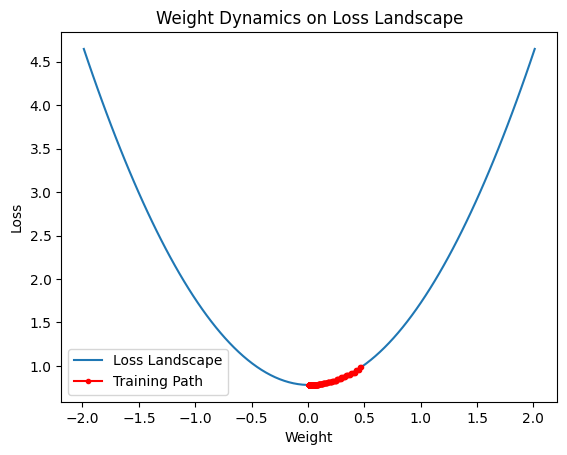

In [21]:
# Plot the loss landscape

# Getting final learned weight and bias
learned_w_random_init = model.linear.weight.item()
learned_b_random_init = model.linear.bias.item()
weight_range = np.linspace(learned_w_random_init - 2, learned_w_random_init + 2, 100)

model_for_landscape = LinearModel()

weight_range_landscape = np.linspace(learned_w_random_init - 2, learned_w_random_init + 2, 100)

# Computing the loss for each weight value in the range
loss_landscape = []
for weight in weight_range_landscape:
    # Updating the model's weight and fixed bias
    model_for_landscape.linear.weight.data.fill_(weight)
    model_for_landscape.linear.bias.data.fill_(learned_b_random_init)
    
    # Forward pass with the updated weight
    y_pred_landscape = model_for_landscape(x_data)
    
    # Computing the loss
    loss = loss_function(y_pred_landscape, y_data)
    loss_landscape.append(loss.item())

# Plotting the loss landscape
plt.plot(weight_range_landscape, loss_landscape, label='Loss Landscape')

# Plotting the trajectory of the weights during training
plt.plot(weights_over_epochs, [loss_landscape[np.argmin(np.abs(weight_range - w))] for w in weights_over_epochs], 'ro-', label='Training Path', markersize=3)
plt.title('Weight Dynamics on Loss Landscape')
plt.xlabel('Weight')
plt.ylabel('Loss')
plt.legend()
plt.show()

Train a singular model

In [16]:
model = SingModel(w0=1.0, d1=2, d2=3, in_features=1, out_features=1)  # create a model instance
loss_fn = torch.nn.MSELoss()  # define a loss function
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)  # create an SGD optimizer

# example data
x = torch.randn(1000)
y = torch.randn(1000)

# training loop
for epoch in range(100):
    y_pred = model(x)  # forward pass
    loss = loss_fn(y_pred, y)  # compute the loss
    optimizer.zero_grad()  # zero the gradients
    loss.backward()  # backpropagation
    optimizer.step()  # update the model parameters
    if epoch % 10 == 0:
                    print(f'Epoch {epoch}, Loss: {loss.item()}, w: {model.weight.item()}')

Epoch 0, Loss: 17.252538681030273, w: 0.9145495295524597
Epoch 10, Loss: 0.9353368878364563, w: 0.9145507216453552
Epoch 20, Loss: 0.9353368878364563, w: 0.9145519137382507
Epoch 30, Loss: 0.9353368878364563, w: 0.9145531058311462
Epoch 40, Loss: 0.9353368878364563, w: 0.9145542979240417
Epoch 50, Loss: 0.9353368878364563, w: 0.9145554900169373
Epoch 60, Loss: 0.9353368878364563, w: 0.9145566821098328
Epoch 70, Loss: 0.9353368878364563, w: 0.9145578742027283
Epoch 80, Loss: 0.9353368878364563, w: 0.9145590662956238
Epoch 90, Loss: 0.9353368878364563, w: 0.9145602583885193


RuntimeError: Can't call numpy() on Tensor that requires grad. Use tensor.detach().numpy() instead.

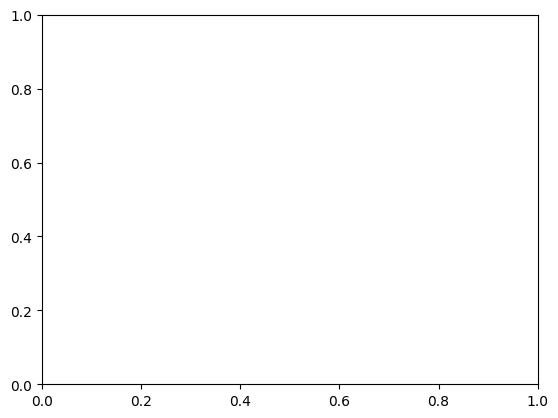

In [13]:
# plot loss curve
epochs = range(100)
plt.plot(epochs, loss)
plt.title('Loss Curve')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.show()

In [ ]:
# Deprecated 

class SingularSGD():
    def __init__(self, lr=0.01, epochs=100, w0=1.0):
        self.lr = lr
        self.epochs = epochs
        self.w0 = w0
        self.w =  torch.randn(1, requires_grad=True)  # initialize w randomly

    def Q(self):
        # polynomial function Q(w)
        return (self.w - self.w0)**2 * (self.w + self.w0)**3

    def loss(self, x, y):
        # compute the loss function
        return (0.5 * self.Q() * x * (2*y - self.Q() * x)).mean()

    def fit(self, X, y):
        optimizer = torch.optim.SGD([self.w], lr=self.lr)
        print(f"Initialisation of w is: {self.w.item()}")
        loss_values = []  # to store loss values for plotting
        for epoch in range(self.epochs):    
            # perform SGD
            for xi, yi in zip(X, y):
                loss = self.loss(xi, yi)
                loss.backward()
                optimizer.step()  # update w
                optimizer.zero_grad()  # reset gradients
            loss_values.append(loss.item())
            if epoch % 10 == 0:
                    print(f'Epoch {epoch}, Loss: {loss_values[epoch]}, w: {self.w.item()}')
        return self.w.item(), loss_values